Linear regression to predict streamflow. Streamflow is divided by 24 to match forcing resolution.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn import metrics, svm, neural_network, ensemble
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
from src import load_data, evaluate
from joblib import Parallel, delayed

In [2]:
data_runoff = load_data.load_discharge_gr4j_vic()

/home/mgauch/runoff-nn/src/load_data.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(os.path.join(dir, f), skiprows=2, skipfooter=1, index_col=False, header=None, names=['runoff'], na_values='-1.2345')
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [3]:
data_runoff[pd.isna(data_runoff['runoff'])].groupby(['station'])['date'].count()  # Count NAs per station

station
02GC018       44
02GG013       31
04214500    1003
Name: date, dtype: int64

In [4]:
# For each station, read which grid cells belong to its subwatershed
station_cell_mapping = pd.read_csv('station_cell_mapping.csv', skiprows=1, names=['station', 'lat', 'lon', 'row', 'col', 'area'])

In [5]:
rdrs_data = load_data.load_rdrs_forcings()

In [6]:
month_onehot=pd.get_dummies(data_runoff['date'].dt.month, prefix='month', columns=['month'])
data_runoff = data_runoff.join(month_onehot)

In [7]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7 * 24
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history // 24 + 1)
use_runoff_history = False

def train_predict(station):
    print(station)
    station_data = data_runoff[data_runoff['station'] == station].set_index('date')
    station_cell_ids = 39 * station_cell_mapping[station_cell_mapping['station'] == station]['col'] \
        + station_cell_mapping[station_cell_mapping['station'] == station]['row']
    station_rdrs = rdrs_data.filter(regex='_(' + '|'.join(map(lambda x: str(x), station_cell_ids)) + ')$', axis=1)
    
    if any(station_data['runoff'].isna()):
        station_data = station_data[~pd.isna(station_data['runoff'])]
        print('Station', station, 'had NA runoff values')
    
    station_data = station_data.resample('1H').ffill()
    station_data['runoff'] = station_data['runoff'] / 24
    station_data = station_data.join(station_rdrs)
    for i in range(1, history + 1):
        station_data = station_data.join(station_rdrs.shift(i, axis=0), rsuffix='_-{}'.format(i))
        if use_runoff_history:
            station_data['runoff_-{}'.format(i)] = station_data['runoff'].shift(i, axis=0)
    
    station_train = station_data.loc[train_start : '2013-12-31']
    station_test = station_data.loc['2014-01-01' : '2014-12-31']
    print('Fitting model for', station)
    m = linear_model.Ridge(alpha=.5)
    m.fit(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff'])
    
    station_test = station_test[~pd.isna(station_test['runoff'])]
    if len(station_test) == 0:
        print('Skipping', station)
        return (station, None, None)
        
    predict = pd.DataFrame(index=station_test.index)
    predict = predict.join(station_test.drop(['station', 'runoff'], axis=1))
    predict['runoff'] = np.nan
    if use_runoff_history:
        for i in range(history):
            for j in range(i + 1, history + 1):
                predict.iloc[i]['runoff_-{}'.format(j)] = station_test.iloc[i]['runoff_-{}'.format(j)]
    print('Predicting', station)
    if not use_runoff_history:
        predict['runoff'] = m.predict(predict.drop('runoff', axis=1))
    else:
        for i in range(len(predict)):
            predict.iloc[i]['runoff'] = m.predict([predict.iloc[i].drop('runoff')])[0]
            for j in range(1, history + 1):
                if (i + j) >= len(predict):
                    break
                predict.iloc[i + j]['runoff_-{}'.format(j)] = predict.iloc[i]['runoff']
    
    return (station, predict[['runoff']], station_test['runoff'])

In [8]:
result_list = Parallel(n_jobs=-1)(delayed(train_predict)(station) for station in data_runoff['station'].unique())

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


04159492 	NSE: clipped before aggregating: -0.466399303472222 	clipped after aggregating: -0.47213571115474107
04200500 	NSE: clipped before aggregating: 0.1869529661037379 	clipped after aggregating: 0.18352105936875895
04161820 	NSE: clipped before aggregating: 0.12324738337147068 	clipped after aggregating: 0.11959207283574125
04174500 	NSE: clipped before aggregating: 0.07579659509075032 	clipped after aggregating: 0.06371589378985942
02GC010 	NSE: clipped before aggregating: 0.39932281804302483 	clipped after aggregating: 0.3959618798230611
02GE007 	NSE: clipped before aggregating: 0.25393106609620475 	clipped after aggregating: 0.2515690709439402
02GD004 	NSE: clipped before aggregating: 0.10985764061191361 	clipped after aggregating: 0.10371619135506305
04214500 	NSE: clipped before aggregating: -1.3124628674421737 	clipped after aggregating: -1.3096852338055203
04213000 	NSE: clipped before aggregating: 0.21933312190115228 	clipped after aggregating: 0.21438779878003267
02GG009

/home/mgauch/runoff-nn/src/evaluate.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04193500 	NSE: clipped before aggregating: -1.4453224204221593 	clipped after aggregating: -1.449043237183142
02GC007 	NSE: clipped before aggregating: 0.20211110356664452 	clipped after aggregating: 0.19848119148380095
04208504 	NSE: clipped before aggregating: -0.41521723023729584 	clipped after aggregating: -0.46592376763177
04199000 	NSE: clipped before aggregating: -0.0925289353693346 	clipped after aggregating: -0.09725639969466049
02GG002 	NSE: clipped before aggregating: 0.2145355424296489 	clipped after aggregating: 0.21306082103822344
04213500 	NSE: clipped before aggregating: -0.22475108922846032 	clipped after aggregating: -0.23751545269746566
02GA038 	NSE: clipped before aggregating: 0.2562570267145514 	clipped after aggregating: 0.25370057148760206
04198000 	NSE: clipped before aggregating: -2.030168739165737 	clipped after aggregating: -2.0195215949472956
04197100 	NSE: clipped before aggregating: 0.003343833889311254 	clipped after aggregating: 0.0011522042312902547
02G

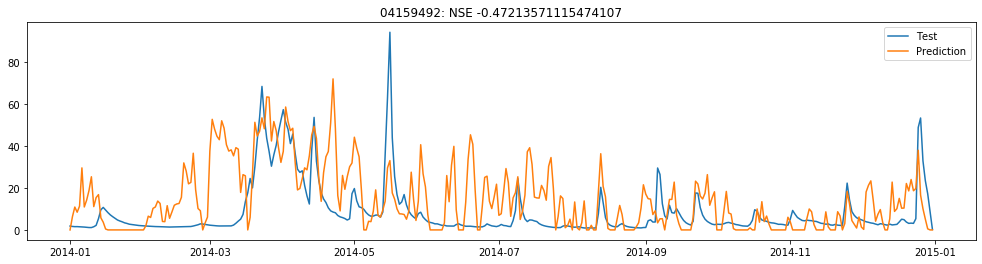

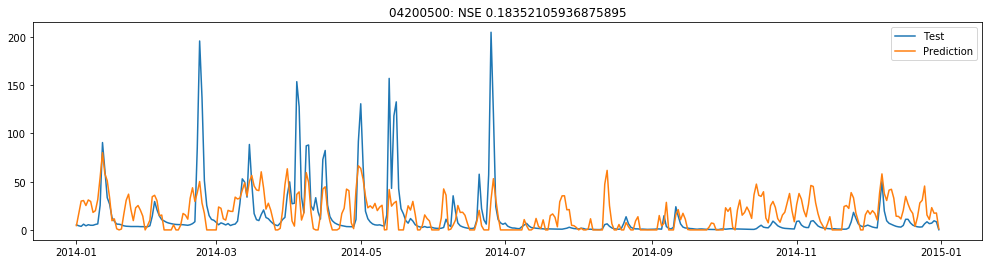

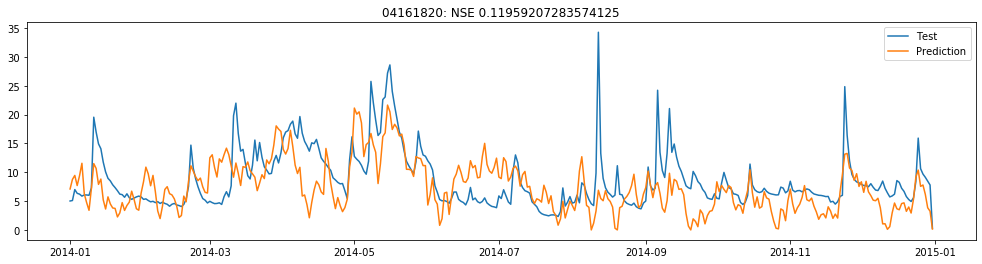

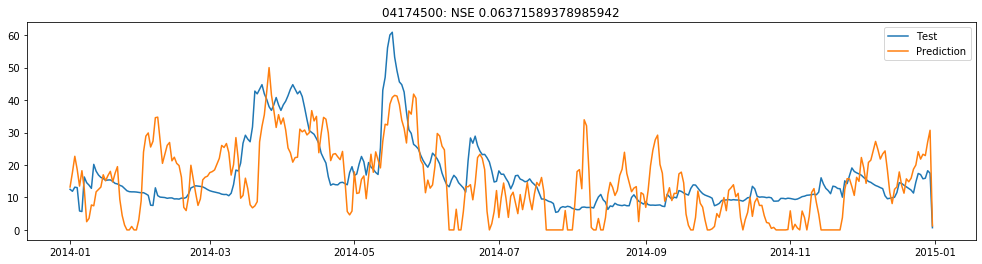

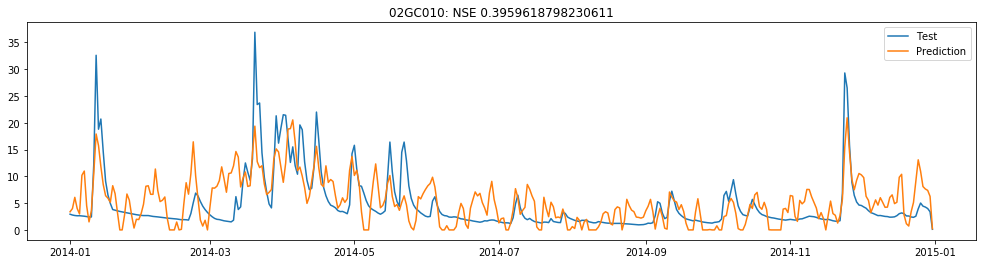

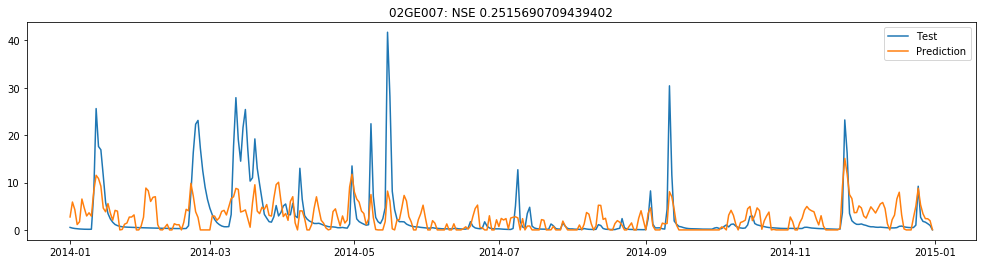

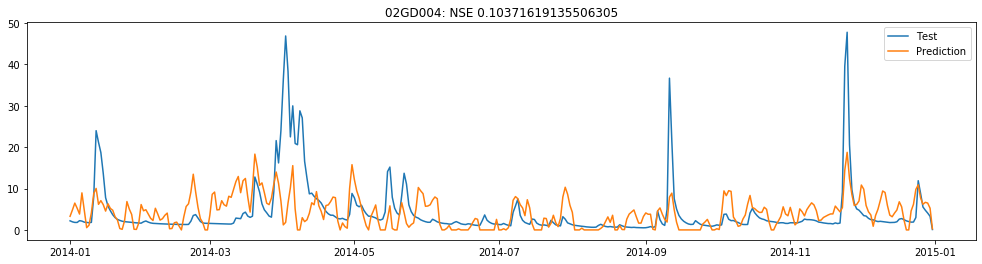

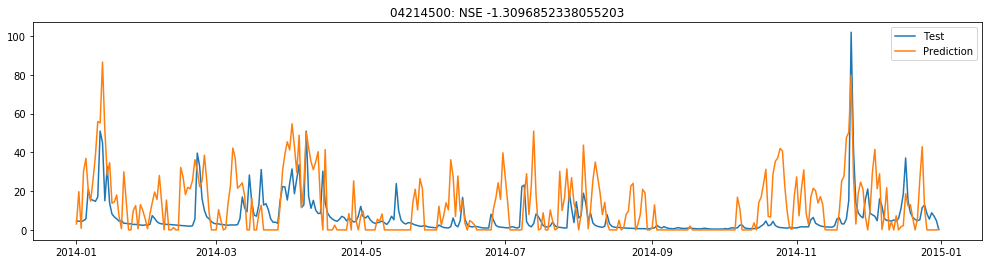

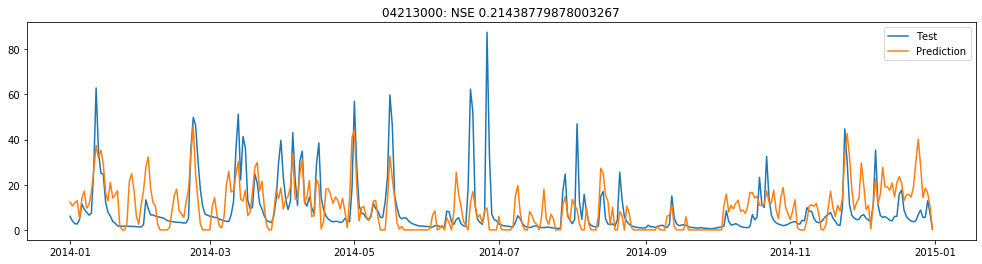

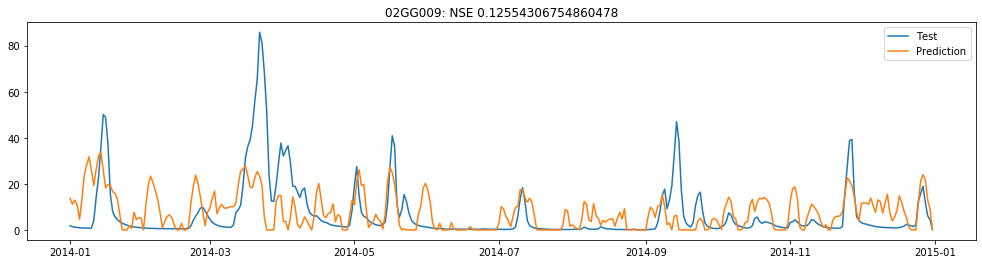

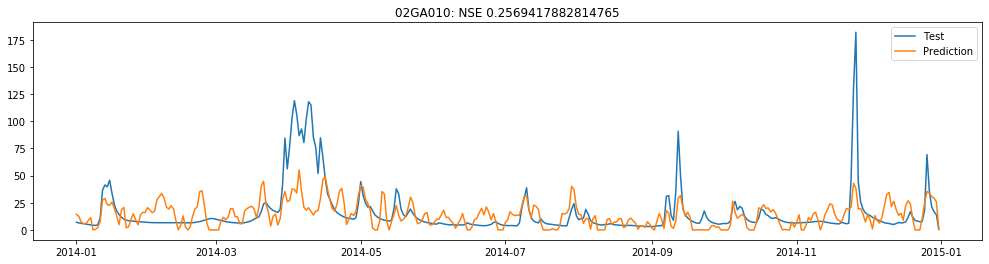

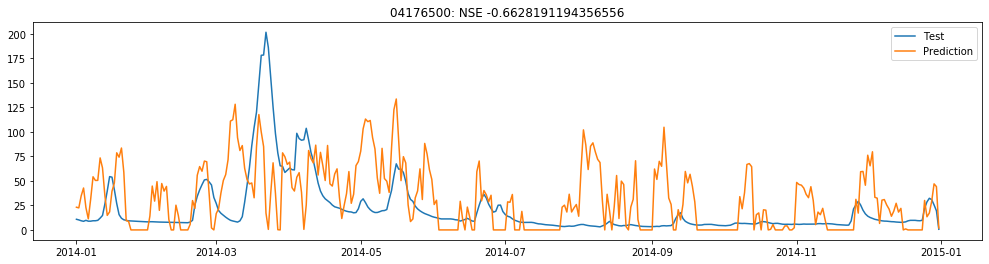

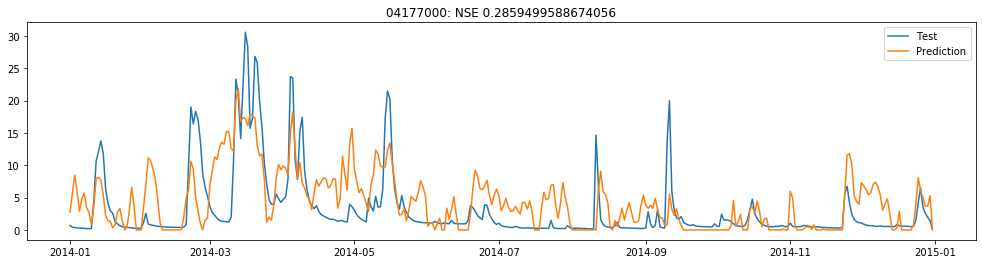

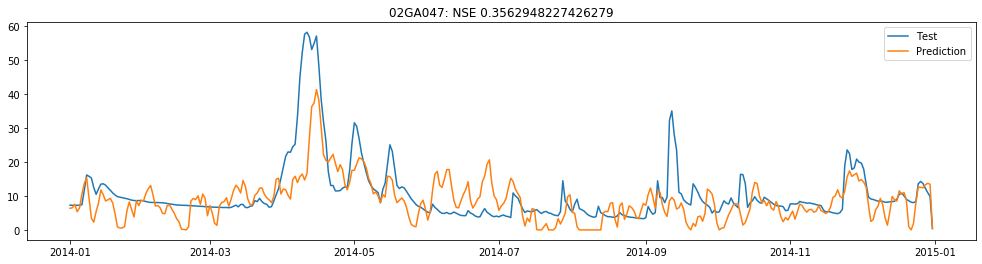

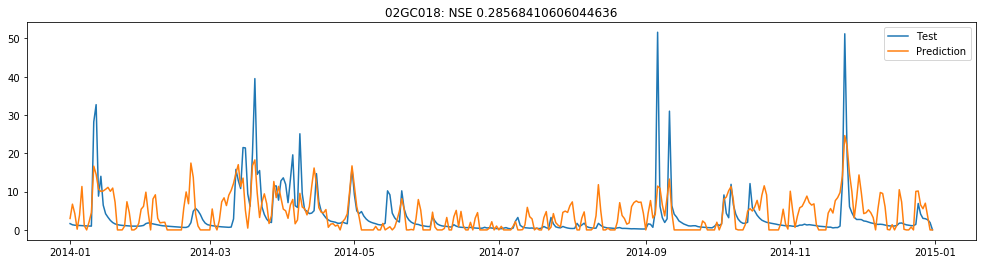

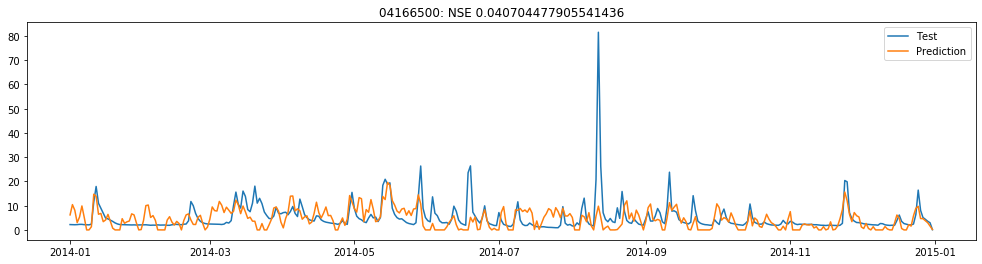

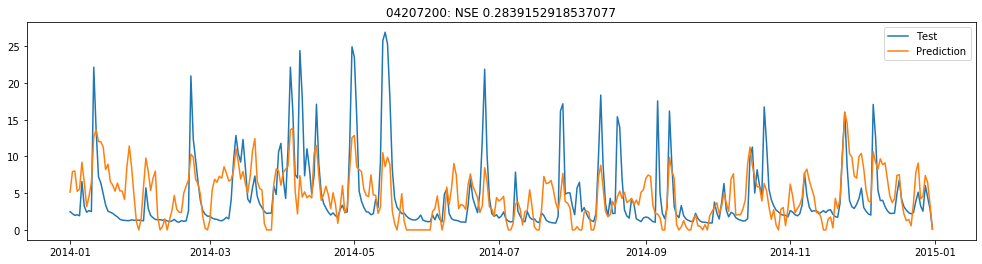

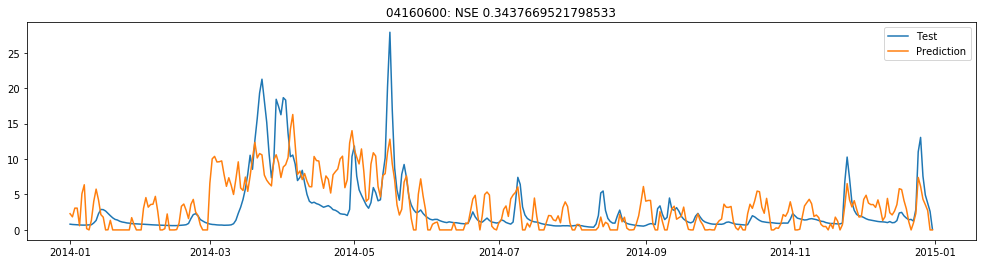

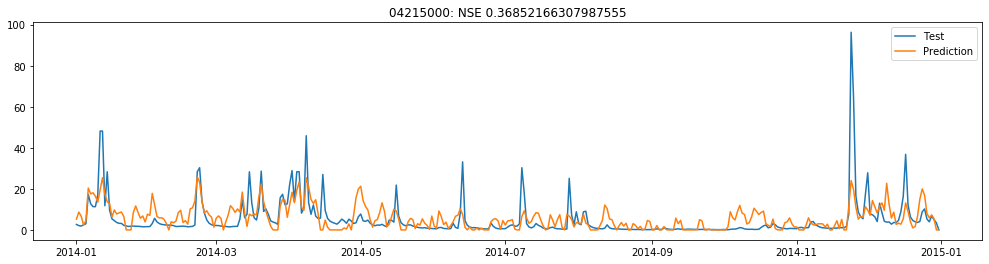

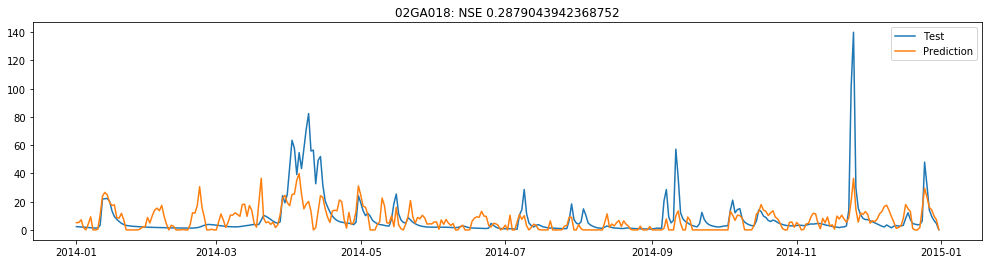

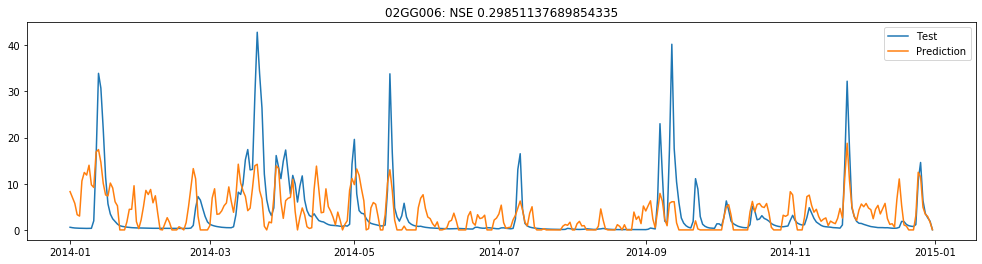

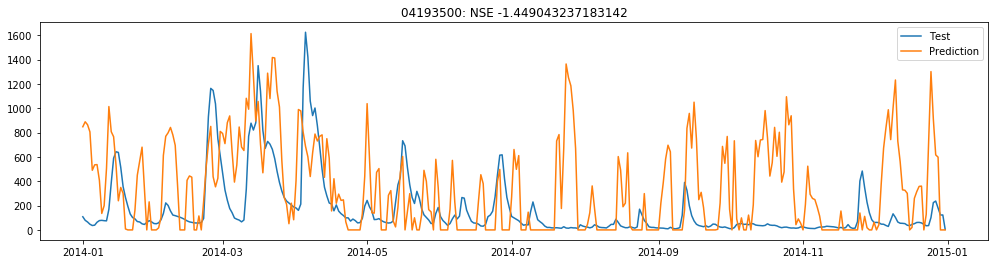

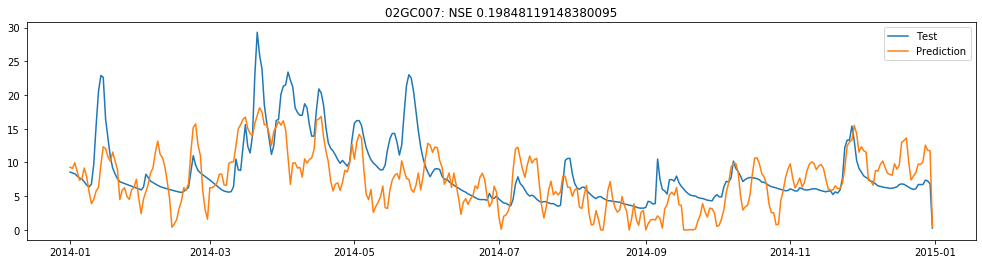

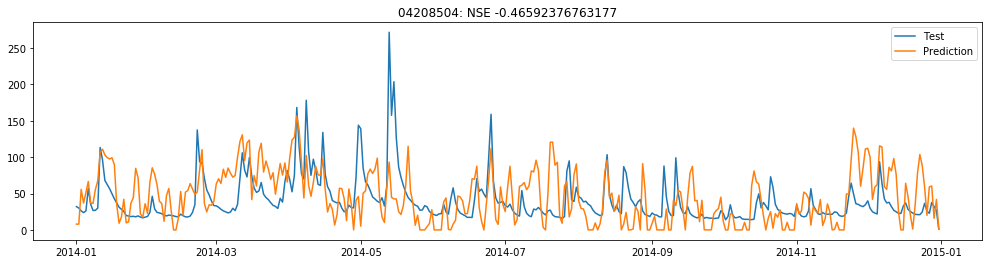

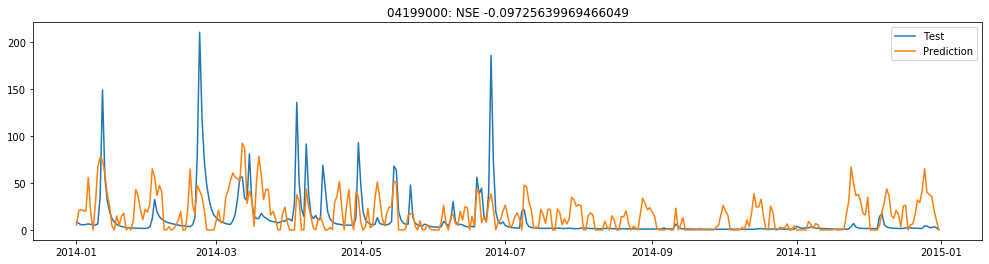

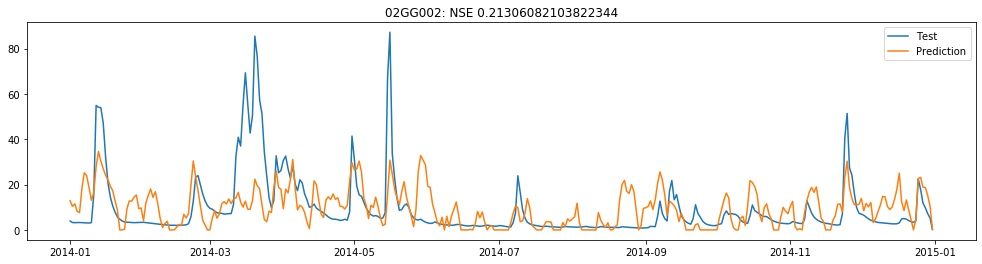

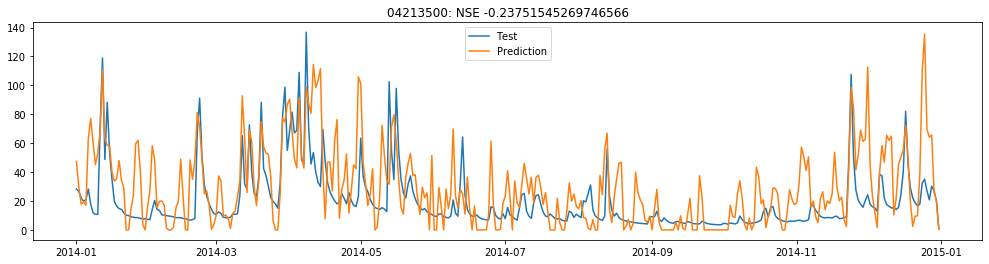

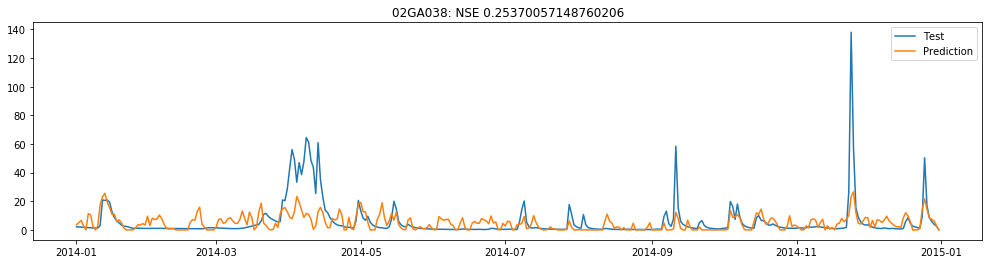

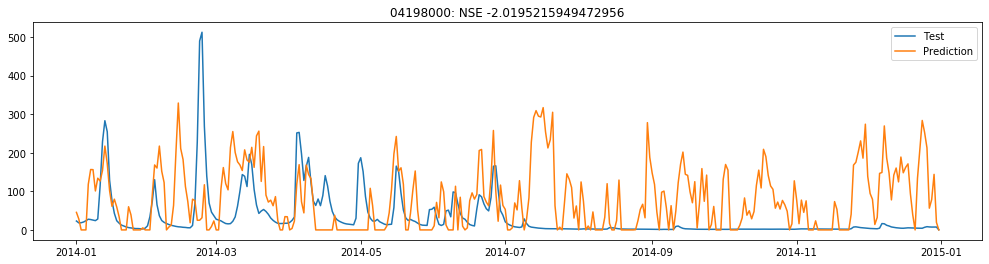

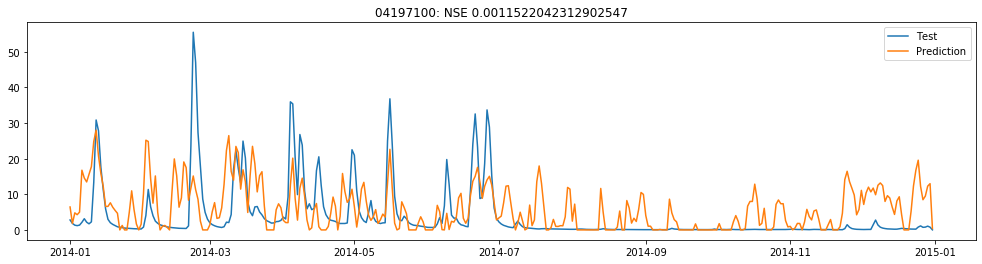

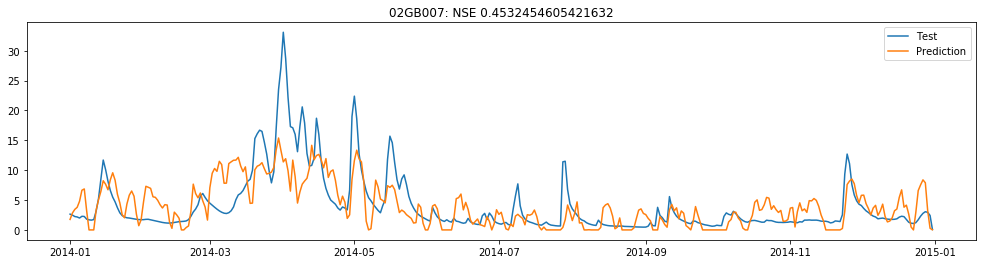

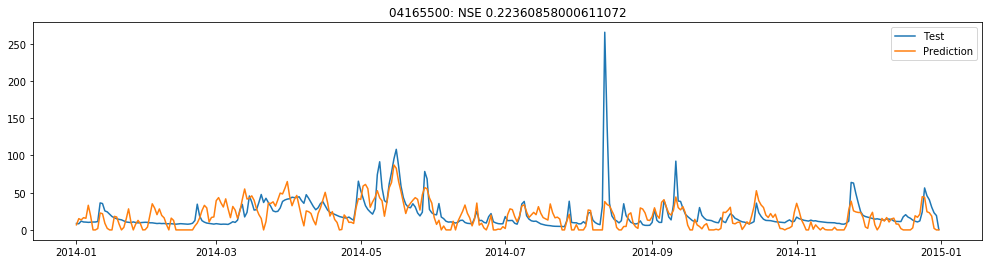

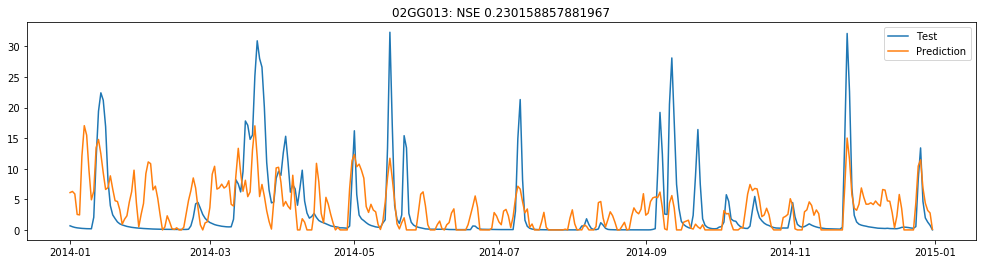

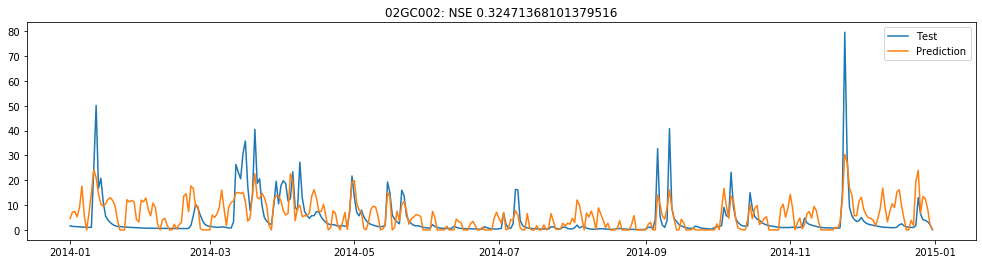

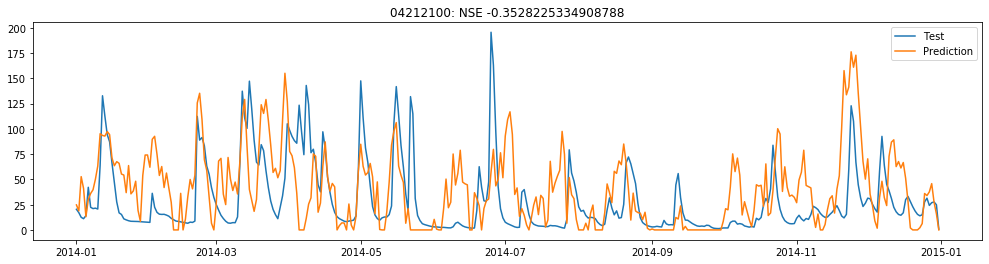

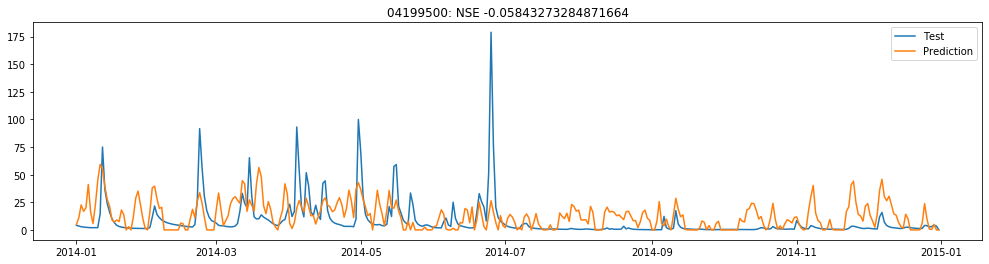

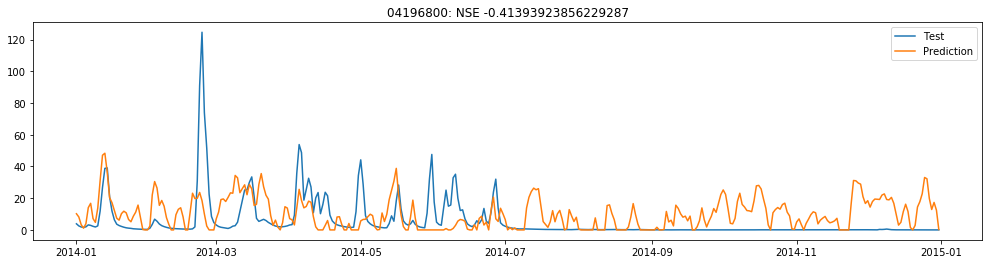

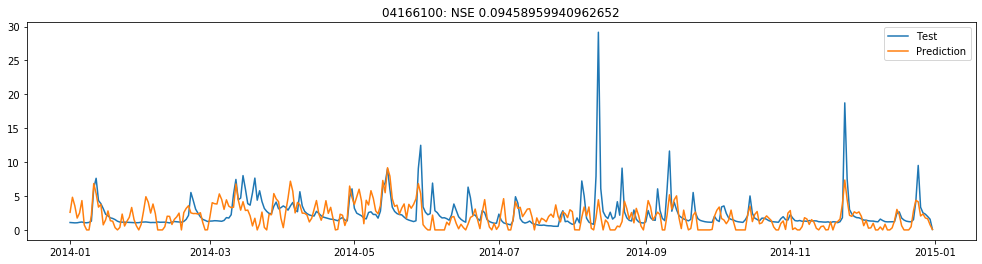

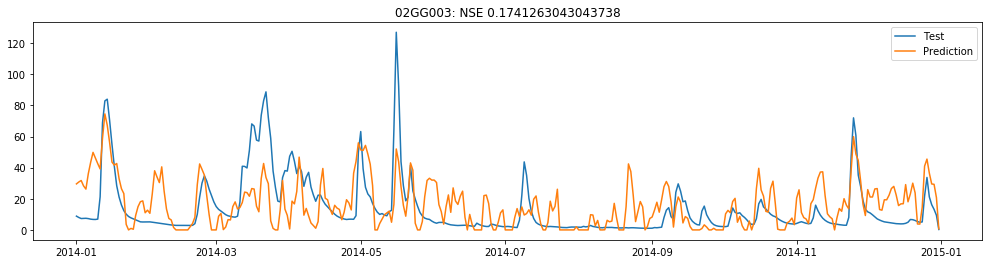

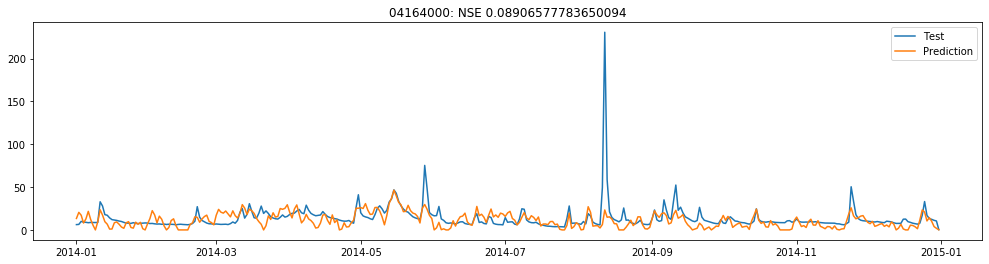

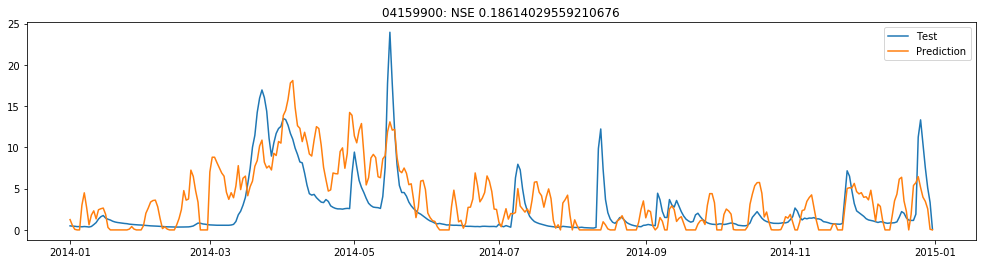

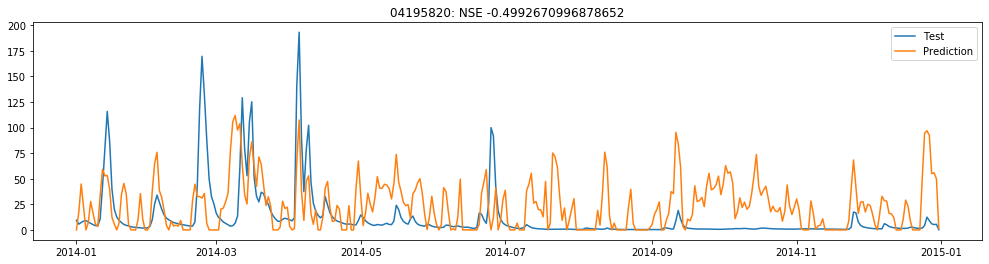

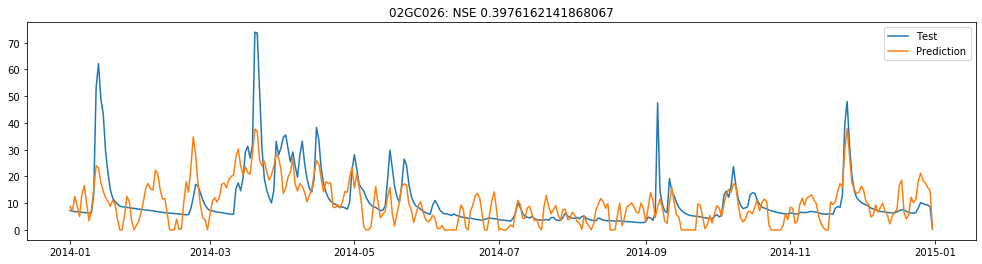

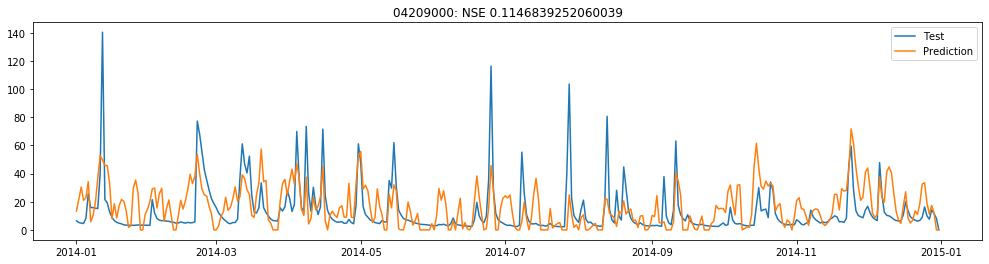

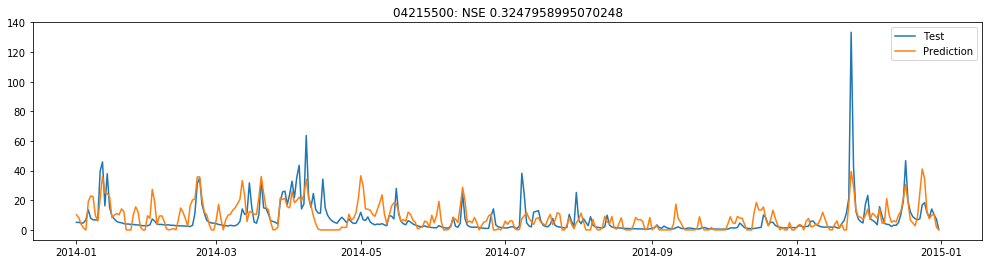

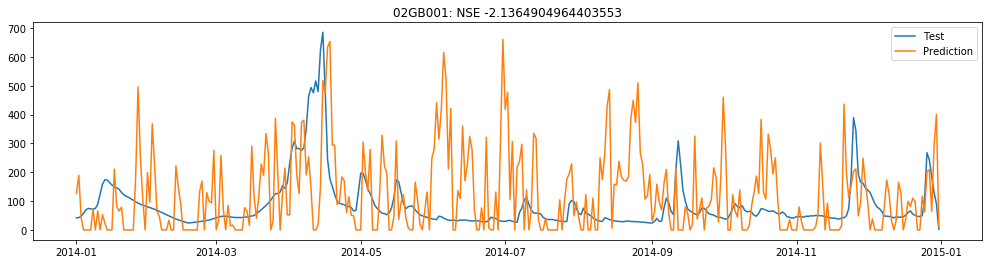

In [9]:
# Evaluate each station
nse_list_clipped_before = []
nse_list_clipped_after = []
#plot_list = ['04159492', '04200500']
for result in result_list:
    station, predict, actual = result
    if predict is None:
        print(station, '\tskipped')
        continue
    nses = evaluate.evaluate_hourly(station, predict['runoff'], actual, plot=True)
    nse_list_clipped_before.append(nses[0])
    nse_list_clipped_after.append(nses[1])
    
    print(station, '\tNSE: clipped before aggregating:', nse_list_clipped_before[-1], 
          '\tclipped after aggregating:', nse_list_clipped_after[-1])
    
print('Median NSE (clipped before aggregating)', np.median(nse_list_clipped_before), '/ Min', np.min(nse_list_clipped_before), '/ Max', np.max(nse_list_clipped_after))
print('Median NSE (clipped after aggregating)', np.median(nse_list_clipped_after), '/ Min', np.min(nse_list_clipped_after), '/ Max', np.max(nse_list_clipped_after))

In [10]:
load_data.pickle_results('LinReg_VIC_divideStreamflow', result_list)

'pickle/LinReg_VIC_divideStreamflow_20190629-224510.pkl'